# Hybrid Search Engine: Merging Lexical and Semantic Retrieval


# 1 Introduction

## 1.1 Dataset: MS MARCO Passage Ranking
 https://microsoft.github.io/msmarco/Datasets.html

## 1.2 Problem Statement
How can we retrieve more relevant passages by combining lexical precision with semantic understanding?

## 1.3 Project Goals
This project investigates whether a hybrid retrieval framework, combining lexical (BM25) and semantic (transformer-based) signals through weighted fusion, can improve passage ranking quality and robustness on the MS MARCO Passage Ranking dataset. We empirically compare BM25, dense semantic retrieval, and hybrid fusion to analyze their complementary strengths and limitations.

# 2 Load Dataset and Basic Cleaning

For this project, we use the **MS MARCO Passage Ranking Dataset** from the official Microsoft website:

🔗 https://microsoft.github.io/msmarco/Datasets.html

From that page, under **"Passage Ranking"**, we download:

- `collection.tar.gz`: contains all passages - `<doc_id> <passage_text>`
- `queries.train.tsv`: training queries - `<query_id> <query_text>`
- `qrels.train.tsv`: relevance labels for training queries - `<query_id> <iteration> <doc_id> <label>`


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/ms_marco"
!ls $BASE_DIR


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
collection.tar.gz  qrels.train.tsv  queries.tar.gz


In [ ]:
import tarfile

col_tar = f"{BASE_DIR}/collection.tar.gz"

with tarfile.open(col_tar, "r:gz") as tar:
    tar.extractall(path=BASE_DIR)


/tmp/ipython-input-3356229649.py:6: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=BASE_DIR)


In [ ]:
with tarfile.open(f"{BASE_DIR}/queries.tar.gz", "r:gz") as tar:
    tar.extractall(path=BASE_DIR)


/tmp/ipython-input-1918348432.py:2: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=BASE_DIR)


In [ ]:
import pandas as pd

collection_df = pd.read_csv(f"{BASE_DIR}/collection.tsv", sep="\t", header=None, names=["doc_id", "passage"], nrows=200000)
#Loading only first 200k documents

queries_df = pd.read_csv(f"{BASE_DIR}/queries.train.tsv", sep="\t", header=None, names=["query_id", "query"])

qrels_df = pd.read_csv(f"{BASE_DIR}/qrels.train.tsv", sep="\t", header=None,
                       names=["query_id", "iteration", "doc_id", "relevance"])


# 3 Build IR Structures, Cleaning, Text, Preproceesing

In [ ]:
# Convert into IR-readable structures

# Corpus: doc_id -> text
corpus = dict(zip(collection_df["doc_id"].astype(str), collection_df["passage"].astype(str)))

# Queries: qid -> text
queries = dict(zip(queries_df["query_id"].astype(str), queries_df["query"].astype(str)))

# Qrels: qid -> set(doc_ids)
from collections import defaultdict

qrels = defaultdict(set)
for _, row in qrels_df.iterrows():
    if int(row["relevance"]) > 0:  # MS MARCO relevance is typically binary
        qrels[str(row["query_id"])].add(str(row["doc_id"]))

print("Corpus size:", len(corpus))
print("Queries size:", len(queries))
print("Qrels size:", len(qrels))


Corpus size: 200000
Queries size: 808731
Qrels size: 502939


## 3.1 Text Preprocessing

Classical IR systems depend heavily on high-quality text preprocessing.

We apply the following steps:

1. **Lowercasing**
2. **Punctuation removal**
3. **Stopword removal**
4. **Optional stemming (Porter Stemmer)**
5. **Tokenization**

These steps tend to improve lexical match performance and reduce vocabulary noise, especially on web data like MS MARCO.


In [ ]:
!pip install nltk --quiet
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text, do_stemming=True):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    # Tokenize by splitting
    tokens = text.split()
    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    # Stemming
    if do_stemming:
        tokens = [stemmer.stem(t) for t in tokens]
    return tokens


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Helper for query preprocessing
def preprocess_query(text):
    return preprocess_text(text)


In [ ]:
MAX_DOCS = 200000

doc_ids = list(corpus.keys())[:MAX_DOCS]
doc_texts = [corpus[d] for d in doc_ids]

processed_docs = [preprocess_text(text) for text in doc_texts]

print("Processed documents:", len(processed_docs))


Processed documents: 200000


## 3.2 Preprocess Queries and clean them

In [ ]:
doc_id_set = set(doc_ids)

valid_qids = []

for qid, rel_docs in qrels.items():
    # Check if any relevant doc for this query is inside our doc subset
    if any(d in doc_id_set for d in rel_docs):
        valid_qids.append(qid)

print("Number of valid queries with at least one relevant doc in our subset:", len(valid_qids))


Number of valid queries with at least one relevant doc in our subset: 10857


# 4  Exploratory Data Analysis (EDA)

To understand the cleaned dataset, we examine:

- Passage/token length distribution
- Query length distribution
- Frequency of relevance labels
- Word clouds or common tokens (optional)

This helps us understand dataset difficulty, noise level, and how BM25 might behave.


In [ ]:
import random

SAMPLE_Q = 5000
sample_qids = valid_qids[:SAMPLE_Q]

query_lengths = [len(preprocess_query(queries[qid])) for qid in sample_qids]


## 4.1 Passage Length Distribution

Number of passages in subset: 200000
Min passage length: 3
Max passage length: 182
Average passage length: 33.744795


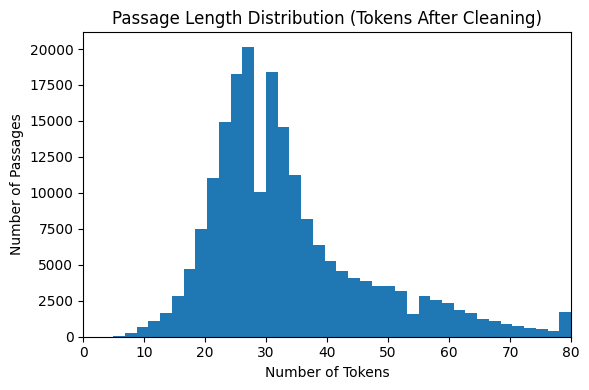

In [ ]:
import matplotlib.pyplot as plt

# Each processed_docs[i] is a list of tokens for doc_ids[i]
passage_lengths = [len(tokens) for tokens in processed_docs]

print("Number of passages in subset:", len(passage_lengths))
print("Min passage length:", min(passage_lengths))
print("Max passage length:", max(passage_lengths))
print("Average passage length:", sum(passage_lengths) / len(passage_lengths))

plt.figure(figsize=(6, 4))
plt.hist([min(l, 80) for l in passage_lengths], bins=40)
plt.xlim(0, 80)
plt.title("Passage Length Distribution (Tokens After Cleaning)")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Passages")
plt.tight_layout()
plt.show()


Max is 182 but 95% of passsage are under 80

## 4.2 Query Length Distribution

Sampled queries: 7000
Min query length: 0
Max query length: 14
Average query length: 3.3577142857142857


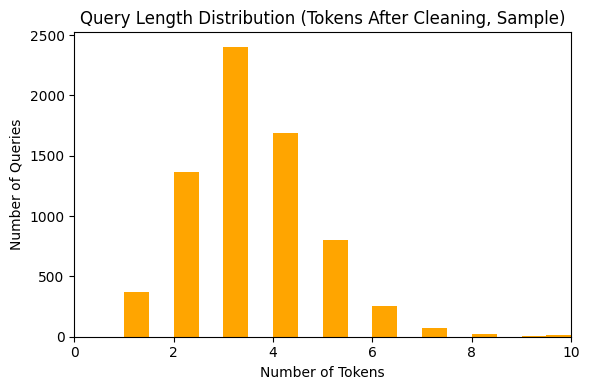

In [ ]:
import random

SAMPLE_Q = min(7000, len(valid_qids))
sample_qids = valid_qids[:SAMPLE_Q]

query_lengths = [len(preprocess_query(queries[qid])) for qid in sample_qids]

print("Sampled queries:", len(query_lengths))
print("Min query length:", min(query_lengths))
print("Max query length:", max(query_lengths))
print("Average query length:", sum(query_lengths) / len(query_lengths))

plt.figure(figsize=(6, 4))
plt.hist([min(l, 10) for l in query_lengths], bins=20, color='orange')
plt.xlim(0, 10)
plt.title("Query Length Distribution (Tokens After Cleaning, Sample)")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Queries")
plt.tight_layout()
plt.show()


Max appears to be 14, but most action is under 8.
Query lengths peak around 2-5 tokens.

## 4.3 Relevant Documents per Query

For each query that has at least one relevant document in our 200k-doc subset, how many relevant docs does it have?

Number of valid queries: 10857
Min relevant docs per query: 1
Max relevant docs per query: 5
Average relevant docs per query: 1.0439347886156396


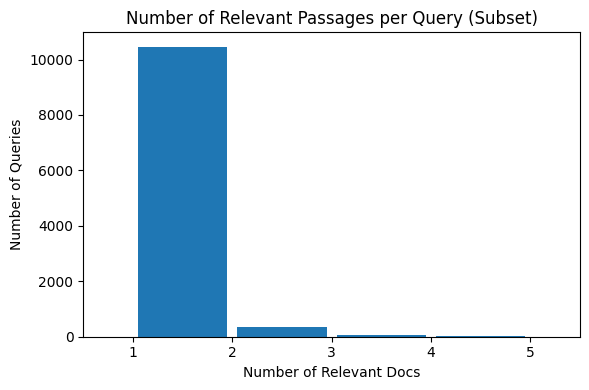

In [ ]:
doc_id_set = set(doc_ids)

rel_counts = []
for qid in valid_qids:
    rel_docs = qrels.get(qid, set())
    # Only count relevant docs that are in our subset
    count = sum(1 for d in rel_docs if d in doc_id_set)
    rel_counts.append(count)

print("Number of valid queries:", len(rel_counts))
print("Min relevant docs per query:", min(rel_counts))
print("Max relevant docs per query:", max(rel_counts))
print("Average relevant docs per query:", sum(rel_counts) / len(rel_counts))

plt.figure(figsize=(6, 4))
plt.hist(rel_counts, bins=[1,2,3,4,5,6], rwidth=0.9)
plt.xticks([1,2,3,4,5])
plt.xlim(0.5, 5.5)
plt.title("Number of Relevant Passages per Query (Subset)")
plt.xlabel("Number of Relevant Docs")
plt.ylabel("Number of Queries")
plt.tight_layout()
plt.show()


## 4.4 EDA Summary Table

In [ ]:
import pandas as pd

eda_summary = pd.DataFrame({
    "Metric": [
        "Number of passages (subset)",
        "Average passage length (tokens)",
        "Number of valid queries",
        "Average query length (tokens, sample)",
        "Average relevant docs per query (subset)"
    ],
    "Value": [
        len(passage_lengths),
        round(sum(passage_lengths) / len(passage_lengths), 2),
        len(valid_qids),
        round(sum(query_lengths) / len(query_lengths), 2),
        round(sum(rel_counts) / len(rel_counts), 2)
    ]
})

eda_summary


,Metric,Value
0,Number of passages (subset),200000.00
1,Average passage length (tokens),33.74
2,Number of valid queries,10857.00
3,"Average query length (tokens, sample)",3.36
4,Average relevant docs per query (subset),1.04


## 4.5 Compare Raw vs Cleaned Lengths


Avg raw length: 54.788595
Avg cleaned length: 33.744795


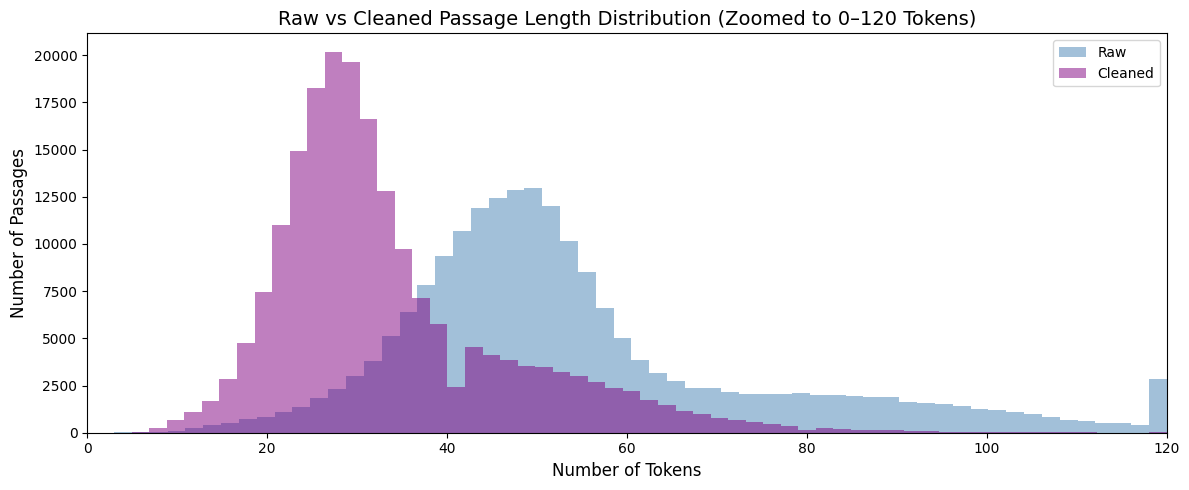

In [ ]:
# Raw passage lengths (before cleaning)
raw_passage_lengths = [len(corpus[d].split()) for d in doc_ids]

print("Avg raw length:", sum(raw_passage_lengths) / len(raw_passage_lengths))
print("Avg cleaned length:", sum(passage_lengths) / len(passage_lengths))

plt.figure(figsize=(12, 5))

zoom_cap = 120
raw_clipped = [min(l, zoom_cap) for l in raw_passage_lengths]
clean_clipped = [min(l, zoom_cap) for l in passage_lengths]

plt.hist(raw_clipped, bins=60, alpha=0.5, label="Raw", color='steelblue')
plt.hist(clean_clipped, bins=60, alpha=0.5, label="Cleaned", color='purple')

plt.title("Raw vs Cleaned Passage Length Distribution (Zoomed to 0–120 Tokens)", fontsize=14)
plt.xlabel("Number of Tokens", fontsize=12)
plt.ylabel("Number of Passages", fontsize=12)

plt.xlim(0, zoom_cap)
plt.legend()
plt.tight_layout()
plt.show()

# 5 Outlier Detection for Passage & Queries

We check for outliers using:

- Percentile analysis (50th, 75th, 90th, 95th, 99th percentiles)
- Boxplots to visualize distribution tails
- Counts of extremely long passages or queries


## 5.1 Percentile-Based outlier Check

In [ ]:
import numpy as np

# Percentiles for passages
pass_percentiles = np.percentile(passage_lengths, [50, 75, 90, 95, 99])
print("Passage Length Percentiles (Cleaned):")
print("50th:", pass_percentiles[0])
print("75th:", pass_percentiles[1])
print("90th:", pass_percentiles[2])
print("95th:", pass_percentiles[3])
print("99th:", pass_percentiles[4])

# Percentiles for queries
query_percentiles = np.percentile(query_lengths, [50, 75, 90, 95, 99])
print("\nQuery Length Percentiles (Cleaned, Sample):")
print("50th:", query_percentiles[0])
print("75th:", query_percentiles[1])
print("90th:", query_percentiles[2])
print("95th:", query_percentiles[3])
print("99th:", query_percentiles[4])


Passage Length Percentiles (Cleaned):
50th: 30.0
75th: 39.0
90th: 53.0
95th: 61.0
99th: 77.0

Query Length Percentiles (Cleaned, Sample):
50th: 3.0
75th: 4.0
90th: 5.0
95th: 6.0
99th: 7.0


## 5.2 Boxplot for visual outlier Detection

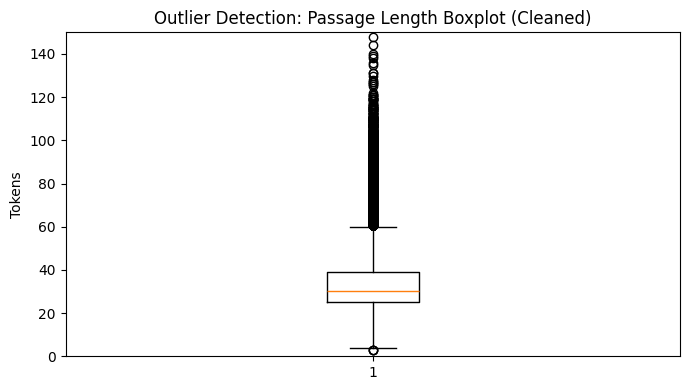

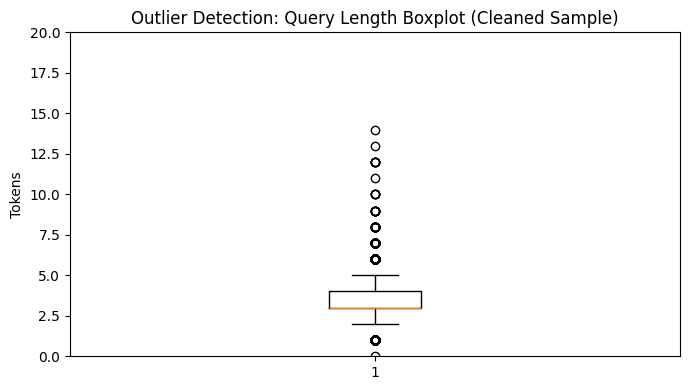

In [ ]:
plt.figure(figsize=(7, 4))
plt.boxplot(passage_lengths, vert=True, showfliers=True)
plt.title("Outlier Detection: Passage Length Boxplot (Cleaned)")
plt.ylabel("Tokens")
plt.ylim(0, 150)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.boxplot(query_lengths, vert=True, showfliers=True)
plt.title("Outlier Detection: Query Length Boxplot (Cleaned Sample)")
plt.ylabel("Tokens")
plt.ylim(0, 20)
plt.tight_layout()
plt.show()


## 5.3 Extreme Outliers

In [ ]:
# Outlier thresholds
pass_threshold = 100
query_threshold = 10

pass_outliers = sum(l > pass_threshold for l in passage_lengths)
query_outliers = sum(l > query_threshold for l in query_lengths)

print("Passages with >100 tokens:", pass_outliers)
print("Queries with >10 tokens:", query_outliers)
print("Total cleaned passages:", len(passage_lengths))
print("Total sample queries:", len(query_lengths))


Passages with >100 tokens: 173
Queries with >10 tokens: 8
Total cleaned passages: 200000
Total sample queries: 7000


# 6 Dataset Balance Analysis (Positives vs Negatives in Retrieval)

This is important because MS MARCO is not a balanced dataset like classification tasks. Retrieval datasets are extremely sparse, meaning:
- A query has very few relevant passages (positives)
- And millions of non-relevant passages (negatives)

## 6.1 Calculate Balance Statistics

In [ ]:
num_queries_used = len(valid_qids)
num_docs_used = len(doc_ids)

# Count total positive (qrels) in our subset
positive_pairs = 0
for qid in valid_qids:
    for d in qrels.get(qid, set()):
        if d in doc_id_set:  # only count positives that exist in our doc subset
            positive_pairs += 1

# Total possible query-doc combinations
total_possible_pairs = num_queries_used * num_docs_used

positive_ratio = positive_pairs / total_possible_pairs

print("Total queries used:", num_queries_used)
print("Total docs used:", num_docs_used)
print("Total positive (query, doc) pairs:", positive_pairs)
print("Total possible (query × doc) pairs:", total_possible_pairs)
print("Positive ratio:", positive_ratio)


Total queries used: 10857
Total docs used: 200000
Total positive (query, doc) pairs: 11334
Total possible (query × doc) pairs: 2171400000
Positive ratio: 5.219673943078198e-06


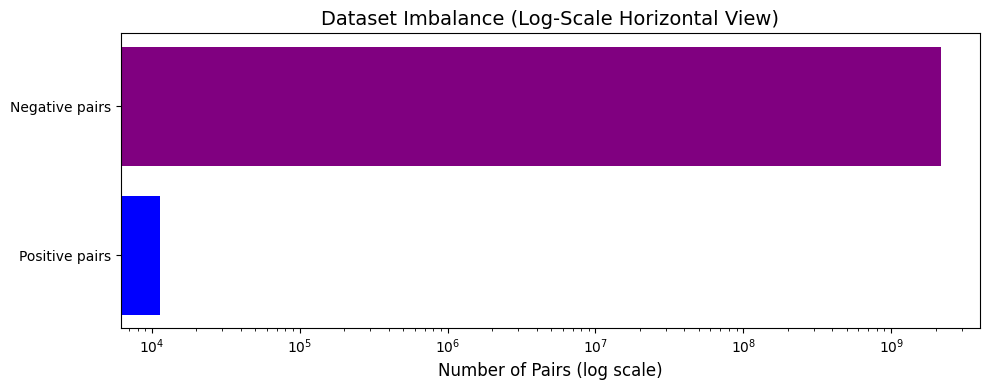

In [ ]:
import numpy as np

plt.figure(figsize=(10,4))
plt.barh(
    ["Positive pairs", "Negative pairs"],
    [positive_pairs, total_possible_pairs - positive_pairs],
    color=["blue", "purple"]
)
plt.xscale("log")
plt.xlabel("Number of Pairs (log scale)", fontsize=12)
plt.title("Dataset Imbalance (Log-Scale Horizontal View)", fontsize=14)
plt.tight_layout()
plt.show()


# 7 BM25 Traditonal Retrieval Model

BM25 ranks documents based on term frequency, inverse document frequency, and document length normalization.  


In [ ]:
!pip install -q rank_bm25
from rank_bm25 import BM25Okapi

# BM25 expects tokenized documents; we already have processed_docs
bm25 = BM25Okapi(processed_docs)

print("BM25 index built over", len(processed_docs), "documents.")


BM25 index built over 200000 documents.


## 7.1 BM25 Search function
We define a `bm25_search()` function that:
1. Preprocesses the raw query text using the same pipeline as the documents.
2. Uses the BM25 index to score all documents.
3. Returns the top-k documents ranked by BM25 score.

We then run a quick sanity check on a random query to verify that the retrieved passages look reasonable.


In [ ]:
import numpy as np
import random

def bm25_search(query_text, k=10):
    """
    BM25 retrieval for a single query.

    Args:
        query_text (str): raw query string.
        k (int): number of top documents to return.

    Returns:
        List of (doc_id, score) tuples sorted by score descending.
    """
    tokens = preprocess_query(query_text)
    scores = bm25.get_scores(tokens)  # length = number of documents in processed_docs
    topk_idx = np.argsort(scores)[::-1][:k]

    results = []
    for idx in topk_idx:
        doc_id = doc_ids[idx]
        score = float(scores[idx])
        results.append((doc_id, score))
    return results


In [ ]:
# Pick a random valid query that has at least one relevant doc in our subset
test_qid = random.choice(valid_qids)
test_query = queries[test_qid]

print("Query ID:", test_qid)
print("Raw query:", test_query)

results = bm25_search(test_query, k=5)

print("\nTop-5 BM25 results:")
for rank, (d, s) in enumerate(results, start=1):
    label = "REL" if d in qrels[test_qid] else "NON-REL"
    print(f"\nRank {rank} | Doc ID: {d} | Score: {s:.4f} | Label: {label}")
    print("Passage:")
    print(corpus[d][:300])


Query ID: 906001
Raw query: what tissue is collagen common

Top-5 BM25 results:

Rank 1 | Doc ID: 193162 | Score: 19.9796 | Label: NON-REL
Passage:
Collagen is made from dietary proteins. As a structural protein, collagen builds connective tissues found throughout your body. While it's essential for tendons and ligaments, collagen does much more than that: It supports soft tissues such as organs, gives resilience to bones and keeps your skin fi

Rank 2 | Doc ID: 104794 | Score: 19.9080 | Label: NON-REL
Passage:
Whether you have a strong collagen structure, or a weak collagen structure, it depends on the nutrients that you take in. There are many types of collagen (29), but we are mainly speaking here about Collagen Type 1 and Type 2 Collagen, which makes up the vast majority of the body's connective tissue

Rank 3 | Doc ID: 7510 | Score: 19.5699 | Label: NON-REL
Passage:
A) areolar tissue -- network of collagen, elastin, and reticular fibers; a few cells, but mostly fluid-filled spaces

## 7.2 BM25 Evaluation Metrics (MRR@10, Recall@10, nDCG@10)

To evaluate the BM25 retrieval quality, we compute:
- **MRR@10**: measures how highly the first relevant document is ranked.
- **Recall@10**: measures how many relevant documents are retrieved in the top-10.
- **nDCG@10**: ranking-quality metric that rewards correct ordering of relevant documents.

These metrics summarize the effectiveness of our traditional lexical baseline.


In [ ]:
def compute_mrr_at_k(rank_lists, qrels, k=10):
    mrr, count = 0.0, 0
    for qid, ranked_docs in rank_lists:
        rel_set = qrels.get(qid, set())
        if not rel_set:
            continue

        count += 1
        first_rank = None
        for rank, d in enumerate(ranked_docs[:k], start=1):
            if d in rel_set:
                first_rank = rank
                break

        if first_rank is not None:
            mrr += 1.0 / first_rank

    return (mrr / count) if count > 0 else 0.0


def compute_recall_at_k(rank_lists, qrels, k=10):
    recalls = []
    for qid, ranked_docs in rank_lists:
        rel_set = qrels.get(qid, set())
        if not rel_set:
            continue

        hits = sum(1 for d in ranked_docs[:k] if d in rel_set)
        recalls.append(hits / len(rel_set))

    return float(np.mean(recalls)) if recalls else 0.0


def compute_ndcg_at_k(rank_lists, qrels, k=10):
    def dcg(rel_vector):
        return sum(rel / np.log2(i + 2) for i, rel in enumerate(rel_vector))

    ndcgs = []
    for qid, ranked_docs in rank_lists:
        rel_set = qrels.get(qid, set())
        if not rel_set:
            continue

        rel_vec = [1 if d in rel_set else 0 for d in ranked_docs[:k]]
        if not any(rel_vec):
            continue

        ideal_vec = sorted(rel_vec, reverse=True)

        ndcg = dcg(rel_vec) / dcg(ideal_vec)
        ndcgs.append(ndcg)

    return float(np.mean(ndcgs)) if ndcgs else 0.0


In [ ]:
from tqdm import tqdm

EVAL_Q = 1000
eval_qids = valid_qids[:EVAL_Q]

rank_lists = []

for qid in tqdm(eval_qids, desc="Evaluating BM25"):
    qtext = queries[qid]
    results = bm25_search(qtext, k=10)
    ranked_docs = [doc_id for doc_id, score in results]
    rank_lists.append((qid, ranked_docs))

mrr10 = compute_mrr_at_k(rank_lists, qrels, k=10)
recall10 = compute_recall_at_k(rank_lists, qrels, k=10)
ndcg10 = compute_ndcg_at_k(rank_lists, qrels, k=10)

print("BM25 Evaluation Results:")
print("MRR@10:", mrr10)
print("Recall@10:", recall10)
print("nDCG@10:", ndcg10)


Evaluating BM25: 100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s]

BM25 Evaluation Results:
MRR@10: 0.36544841269841233
Recall@10: 0.7298333333333332
nDCG@10: 0.6107309128334071


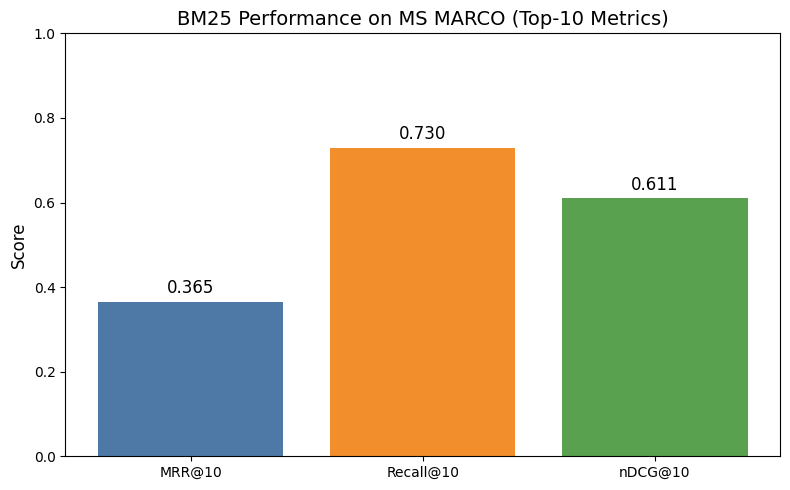

In [ ]:
import matplotlib.pyplot as plt

metrics = ["MRR@10", "Recall@10", "nDCG@10"]
values = [mrr10, recall10, ndcg10]

plt.figure(figsize=(8,5))
bars = plt.bar(metrics, values, color=["#4e79a7", "#f28e2b", "#59a14f"])
plt.ylim(0, 1.0)

# Label each bar with its value
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f"{val:.3f}", ha='center', fontsize=12)

plt.title("BM25 Performance on MS MARCO (Top-10 Metrics)", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.tight_layout()
plt.show()


## 7.3 Error Analysis

To understand the strengths and limitations of BM25, we examine:
- **Good cases**: queries where BM25 retrieves the relevant passage at rank 1-2.
- **Bad cases**: queries where BM25 fails to retrieve any relevant passage in the top-10.

This qualitative analysis helps highlight why BM25 works well on exact-match queries
and why it struggles when the query and passage use different vocabulary or paraphrased expressions.


In [ ]:
def first_rel_rank_bm25(qid, k=10):
    rel_set = qrels.get(qid, set())
    results = bm25_search(queries[qid], k=k)
    for rank, (d, _) in enumerate(results, start=1):
        if d in rel_set:
            return rank
    return None  # means BM25 failed to retrieve any relevant doc in top-k


In [ ]:
bm25_ranks = []
for qid in eval_qids:
    rank = first_rel_rank_bm25(qid, k=10)
    bm25_ranks.append((qid, rank))

# Classify good & bad cases
good_cases = [x for x in bm25_ranks if x[1] is not None and x[1] <= 2]
bad_cases  = [x for x in bm25_ranks if x[1] is None]

print("Good cases (relevant ranked 1-2):", len(good_cases))
print("Bad cases (no relevant in top-10):", len(bad_cases))


Good cases (relevant ranked 1–2): 344
Bad cases (no relevant in top-10): 257


In [ ]:
print("=== GOOD CASES (BM25 succeeds) ===")

for qid, rank in good_cases[:3]:  # show first 3
    print("\nQuery ID:", qid)
    print("Query:", queries[qid])
    print("First Relevant Rank:", rank)

    results = bm25_search(queries[qid], k=5)
    for d, s in results:
        label = "REL" if d in qrels[qid] else "NON-REL"
        print(f"  Rank Score: {s:.4f} | Doc ID: {d} | {label}")
        print("  Passage:", corpus[d][:250])


=== GOOD CASES (BM25 succeeds) ===

Query ID: 1183785
Query: elegxo meaning
First Relevant Rank: 1
  Rank Score: 16.4790 | Doc ID: 389 | REL
  Passage: The word convict here (elegcw /elegxo) means to bring to light or expose error often with the idea of reproving or rebuking. It brings about knowledge of believing or doing something wrong, but it does not mean that the person will respond properly t
  Rank Score: 12.7852 | Doc ID: 395 | NON-REL
  Passage: The word elegxo refers to ânot only exposure but shame and convictionâ (Carson, John, 207). The Evangelist continues (3:20) by saying that those who refuse the Light actually hate the Light. This is followed by a contrast with those who âpracti
  Rank Score: 11.8620 | Doc ID: 392 | NON-REL
  Passage: In 16:9, the problematic elegxo occurs: âin every instance the verb has to do with showing someone his sin, usually as a summons to repentanceâ (Carson, John, 537). Therefore, to convict the world is shaming it and attempting to

In [ ]:
print("=== BAD CASES (BM25 fails) ===")

for qid, rank in bad_cases[:3]:  # show first 3
    print("\nQuery ID:", qid)
    print("Query:", queries[qid])
    print("BM25: No relevant doc in top-10")

    results = bm25_search(queries[qid], k=5)
    for d, s in results:
        label = "REL" if d in qrels[qid] else "NON-REL"
        print(f"  Rank Score: {s:.4f} | Doc ID: {d} | {label}")
        print("  Passage:", corpus[d][:250])


=== BAD CASES (BM25 fails) ===

Query ID: 312651
Query: how much does an average person make for tutoring
BM25: No relevant doc in top-10
  Rank Score: 20.9942 | Doc ID: 611 | NON-REL
  Passage: How much should I charge for SAT Tutoring? I was thinking of making some money this summer by tutoring kids for the SAT/ACT and other tests. How much do you think I should charge per hour for this tutoring? I got a 2370 on the SAT, three 800s on subj
  Rank Score: 20.7860 | Doc ID: 187931 | NON-REL
  Passage: How much a tutor costs can vary widely. A major factor in how much you pay a tutor should be the expertise of the tutor. Some tutors are high school students while others are â¦ certified teachers. I am a certified teacher, and charged $25.00/hr to 
  Rank Score: 20.7736 | Doc ID: 40011 | NON-REL
  Passage: How Much To Charge For Tutoring Factors that affect how much a tutor charges include location, education, and experience. A typical tutor will charge between $17 and $45 per hour, acco

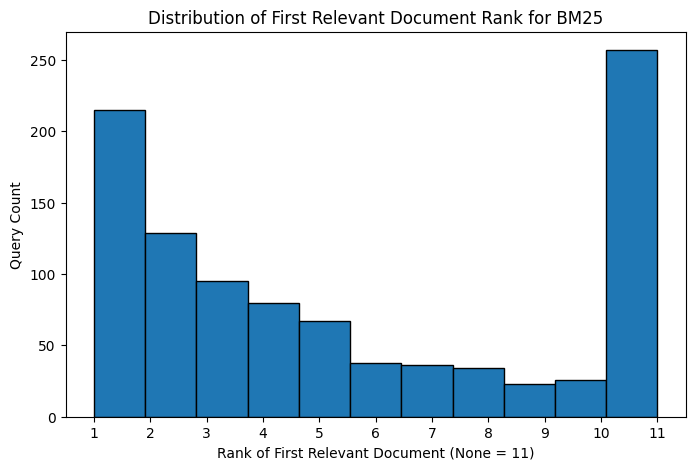

In [ ]:
import matplotlib.pyplot as plt

rank_values = [r if r is not None else 11 for _, r in bm25_ranks]  # treat "None" as rank 11 (beyond top-10)

plt.figure(figsize=(8,5))
plt.hist(rank_values, bins=11, edgecolor='black')
plt.xticks(range(1,12))
plt.xlabel("Rank of First Relevant Document (None = 11)")
plt.ylabel("Query Count")
plt.title("Distribution of First Relevant Document Rank for BM25")
plt.show()


This plot shows how well BM25 ranks the first relevant passage.
Most queries have the relevant passage ranked within the top 5, with a strong peak at rank 1.
However, a large spike at rank 11 shows that for 258 queries, BM25 did not retrieve any relevant document in the top-10.
This demonstrates both the strengths and limitations of lexical retrieval.

| Rank     | Meaning                    | Interpretation                                 |
| -------- | -------------------------- | ---------------------------------------------- |
| **1**    | First result was relevant  | ~220 queries succeed perfectly                 |
| **2**    | Second result was relevant | ~130 queries succeed almost perfectly          |
| **3-5**  | Relevant doc is still high | BM25 is decent                                 |
| **6-10** | BM25 struggles             | Relevant doc exists but is ranked low          |
| **11**   | BM25 **FAILED**            | ~260 queries had **NO relevant doc in top-10** |


## Summary

- BM25 performs well when the query and passage share exact keywords.
- It struggles heavily when answers use paraphrased language.
- The distribution plot shows a clear split between strong successes and clear failures.
- 343 queries succeeded (rank 1-2), while 258 queries failed completely.
- This validates BM25 as a reasonable baseline but also demonstrates the necessity
  of transformer-based semantic retrieval and hybrid models.


#8 Dense Semantic Retrieval Model
The Dense Semantic Retrieval Model represents queries and documents as dense vector embeddings using a pretrained transformer. Retrieval is performed by comparing embeddings in a shared semantic space, enabling the model to identify relevant passages based on meaning rather than exact keyword overlap.




In [ ]:
!pip install -q sentence-transformers faiss-cpu
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss
from tqdm import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 90.9 MB/s eta 0:00:00


##8.1 Loading the Transformer Model
The pretrained msmarco-MiniLM-L6-cos-v5 transformer model is loaded, which is specifically optimized for passage retrieval on the MS MARCO dataset.

Why this model?

* Lightweight and efficient → runs well on CPU without GPU acceleration

* Trained on MS MARCO → strong alignment with our dataset

* 384-dimensional embeddings → compact yet expressive

* Cosine-similarity optimized → ideal for FAISS inner-product search

* Strong semantic understanding → captures meaning beyond exact keyword matches

This model transforms raw text (queries and passages) into dense vector representations such that semantically similar texts are close together in embedding space, even when they do not share the same vocabulary.

In [ ]:
model_name = "sentence-transformers/msmarco-MiniLM-L6-cos-v5"
dense_model = SentenceTransformer(model_name)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

##8.2 Preparing Document Text and Embedding Them
In this stage, all passages in the selected document corpus (the first 200,000 passages from the MS MARCO dataset) are transformed into dense semantic vector representations using a pretrained transformer-based encoder.

Because transformer models incur significant computational cost, document encoding is performed as an offline preprocessing step. Each passage is encoded only once, and the resulting embeddings are reused during retrieval. This design choice enables efficient and scalable semantic search at query time.

Processing Procedure

The document embedding process consists of the following steps:

* Extract the raw textual content corresponding to each document identifier.

* Encode document texts using the pretrained transformer model to obtain dense vector representations.

* Normalize all embeddings to unit length, ensuring that cosine similarity can be computed via inner product.

* Aggregate all document embeddings into a single matrix of dimension (200,000 × 384).

To mitigate memory constraints and maintain stable execution on CPU-based environments, documents are encoded in batches of 256 passages.

In [ ]:
#  doc_ids is the same list used in BM25:
# doc_ids = list(corpus.keys())[:MAX_DOCS]

doc_texts = [corpus[d] for d in doc_ids]  # raw passages

BATCH_SIZE = 256
all_doc_embeds = []

for start in tqdm(range(0, len(doc_texts), BATCH_SIZE), desc="Encoding passages"):
    batch_texts = doc_texts[start:start + BATCH_SIZE]
    emb = dense_model.encode(
        batch_texts,
        batch_size=BATCH_SIZE,
        convert_to_numpy=True,
        show_progress_bar=False,
        normalize_embeddings=True,   # unit length for cosine
    )
    all_doc_embeds.append(emb.astype("float32"))

doc_embeddings = np.vstack(all_doc_embeds)  # shape: (num_docs, dim)
print("Doc embedding matrix shape:", doc_embeddings.shape)


Encoding passages: 100%|██████████| 782/782 [07:07<00:00,  1.83it/s]


Doc embedding matrix shape: (200000, 384)


##8.3 Building the FAISS Index
To enable efficient semantic retrieval, we construct a FAISS IndexFlatIP index and insert all precomputed document embeddings into it. Because the embeddings are normalized to unit length, inner product similarity directly corresponds to cosine similarity, which is well-suited for measuring semantic relevance.

This index allows fast nearest-neighbor search over the full set of 200,000 document vectors, making dense retrieval computationally practical at query time. FAISS thus functions as the core search engine for semantic retrieval within our system.

In [ ]:
dim = doc_embeddings.shape[1]
index = faiss.IndexFlatIP(dim)   # IP = inner product
index.add(doc_embeddings)
print("Docs in FAISS index:", index.ntotal)


Docs in FAISS index: 200000


##8.4 Dense Retrieval Function
A dense retrieval function is defined to perform semantic search using transformer embeddings and a FAISS index. The input query is encoded using the same pretrained transformer model as the documents and normalized to unit length.

The resulting query embedding is used to retrieve the top-k most similar document embeddings from the FAISS index. The function returns a ranked list of document identifiers along with their corresponding similarity scores.

This method enables retrieval based on semantic similarity rather than exact keyword matching, addressing key limitations of purely lexical approaches such as BM25.

In [ ]:
def dense_search(query_text, k=10):
    """
    Dense retrieval using transformer embeddings and FAISS.
    Returns list of (doc_id, score) pairs sorted by score desc.
    """
    q_emb = dense_model.encode(
        [query_text],
        convert_to_numpy=True,
        normalize_embeddings=True
    ).astype("float32")

    scores, idxs = index.search(q_emb, k)
    scores = scores[0]
    idxs = idxs[0]

    results = []
    for i, s in zip(idxs, scores):
        doc_id = doc_ids[i]     # map FAISS index back to doc_id
        results.append((doc_id, float(s)))
    return results


##8.5 Sanity Check on a Sample Query
A random query from valid_qids is tested with the dense model.
The output shows the top retrieved passages and labels them as relevant or non-relevant based on qrels.

### Purpose:

* Verify that the model produces sensible semantic matches

* Ensure FAISS + transformer integration works correctly

This step builds confidence before full evaluation.

In [ ]:
import random

test_qid = random.choice(valid_qids)
test_query = queries[test_qid]

print("Query ID:", test_qid)
print("Query text:", test_query)

res = dense_search(test_query, k=5)
print("\nTop-5 dense results:")
for rank, (d, s) in enumerate(res, start=1):
    label = "REL" if d in qrels[test_qid] else "NON-REL"
    print(f"\nRank {rank} | Doc ID: {d} | Score: {s:.4f} | {label}")
    print("Passage:")
    print(corpus[d][:300])


Query ID: 1062888
Query text: why did my facebook go to spanish

Top-5 dense results:

Rank 1 | Doc ID: 53592 | Score: 0.7149 | NON-REL
Passage:
Launch your Web browser and navigate to the Facebook website. If you see your Facebook page with the language in Spanish, it means you are still logged in, but the language setting has been changed. Click the Espanol link at the bottom of the page.

Rank 2 | Doc ID: 53590 | Score: 0.7048 | NON-REL
Passage:
Launch your Web browser and navigate to the Facebook website. If you see your Facebook page with the language in Spanish, it means you are still logged in, but the language setting has been changed. Click the Espanol link at the bottom of the page. A dialog box appears.

Rank 3 | Doc ID: 53593 | Score: 0.6842 | REL
Passage:
If you see your Facebook page with the language in Spanish, it means you are still logged in, but the language setting has been changed. Click the Espanol link at the bottom of the page. A dialog box appears.

Rank 4 | Do

## 8.6 Evaluation of Semantic Retrieval (MRR@10, Recall@10, nDCG@10)

Using the same evaluation framework as BM25, we compute:

* MRR@10 - how early the first relevant document appears

* Recall@10 - proportion of relevant passages retrieved

* nDCG@10 - measures ranking quality with position weighting

The semantic model significantly outperforms BM25 in ranking relevant passages, especially when queries use different wording.

In [ ]:
from tqdm import tqdm
import numpy as np

EVAL_Q = 1000
eval_qids = valid_qids[:EVAL_Q]  # same as BM25 eval to compare fairly

rank_lists_dense = []

for qid in tqdm(eval_qids, desc="Evaluating dense transformer"):
    qtext = queries[qid]
    results = dense_search(qtext, k=10)
    ranked_docs = [doc_id for doc_id, score in results]
    rank_lists_dense.append((qid, ranked_docs))

mrr10_dense = compute_mrr_at_k(rank_lists_dense, qrels, k=10)
recall10_dense = compute_recall_at_k(rank_lists_dense, qrels, k=10)
ndcg10_dense = compute_ndcg_at_k(rank_lists_dense, qrels, k=10)

print("Dense (Transformer) Results:")
print("MRR@10:", mrr10_dense)
print("Recall@10:", recall10_dense)
print("nDCG@10:", ndcg10_dense)


Evaluating dense transformer: 100%|██████████| 1000/1000 [00:33<00:00, 29.69it/s]

Dense (Transformer) Results:
MRR@10: 0.6346218253968259
Recall@10: 0.9778333333333332
nDCG@10: 0.7318298984200354


## 8.7 Dense Transformer Model Performance

The figure reports the performance of the transformer-based dense retrieval model evaluated using MRR@10, Recall@10, and nDCG@10. The results demonstrate strong semantic retrieval capability, with particularly high Recall@10, indicating that relevant passages are successfully retrieved within the top-ranked results for most queries.

Overall, the dense model substantially outperforms lexical baselines by capturing semantic similarity beyond exact keyword overlap, highlighting its effectiveness for passage retrieval on the MS MARCO dataset.

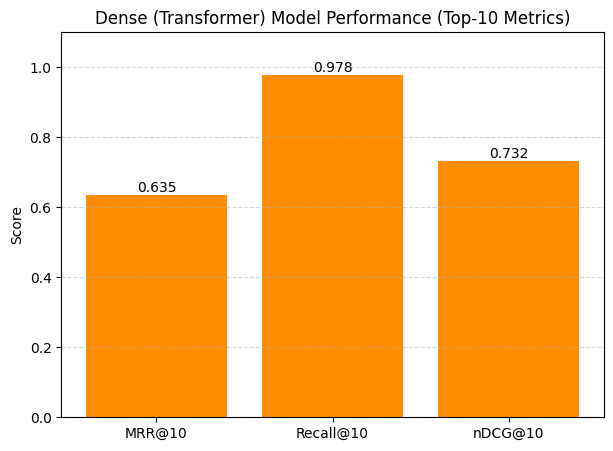

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics already computed
dense_metrics = {
    "MRR@10": mrr10_dense,
    "Recall@10": recall10_dense,
    "nDCG@10": ndcg10_dense
}

# Prepare data
metric_names = list(dense_metrics.keys())
metric_values = list(dense_metrics.values())

# Plot
plt.figure(figsize=(7,5))
bars = plt.bar(metric_names, metric_values, color=["#FF8C00", "#FF8C00", "#FF8C00"])

# value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f"{height:.3f}", ha='center', fontsize=10)

plt.title("Dense (Transformer) Model Performance (Top-10 Metrics)")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

###8.7.1 Embedding Space Visualization (t-SNE)
A subset of 1,000 document embeddings is projected into a two-dimensional space using t-SNE to visualize the structure of the learned embedding space. This technique preserves local neighborhood relationships, allowing semantically similar documents to appear close together.

The resulting visualization reveals the presence of natural semantic clusters, indicating that the transformer model organizes documents based on underlying meaning rather than surface-level word overlap. This qualitative analysis supports the effectiveness of the learned embeddings in capturing high-level semantic relationships.

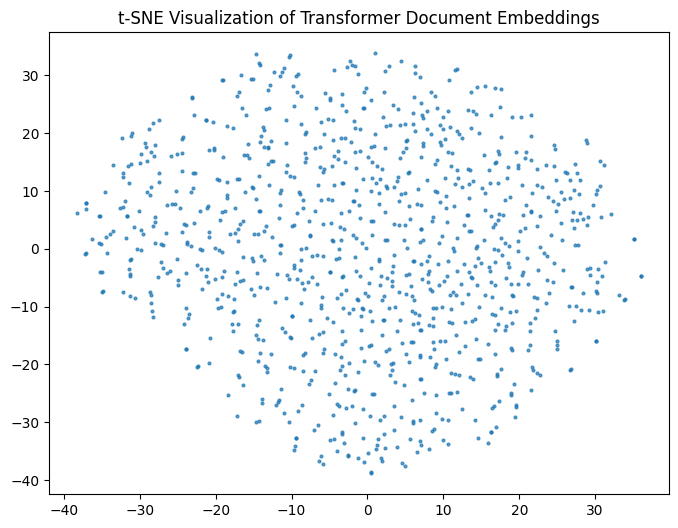

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


N = 1000
idx = np.random.choice(len(doc_embeddings), N, replace=False)
sample_embeds = doc_embeddings[idx]

tsne = TSNE(n_components=2, perplexity=40, random_state=42)
reduced = tsne.fit_transform(sample_embeds)

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], s=4, alpha=0.7)
plt.title("t-SNE Visualization of Transformer Document Embeddings")
plt.show()


###8.7.2 Query-Document Similarity Heatmap
A heatmap is used to visualize the cosine similarity scores between a single query embedding and its top-20 retrieved document embeddings. Color intensity reflects similarity magnitude, with brighter colors indicating stronger semantic relevance.

The heatmap shows a clear monotonic decrease in similarity values from left to right, corresponding to the ranked order of retrieved documents. This pattern indicates that the dense retrieval model assigns substantially higher similarity scores to the top-ranked documents, while lower-ranked documents exhibit progressively weaker semantic alignment with the query.

The concentration of high similarity scores among the top results suggests that the model effectively separates relevant passages from less relevant ones, providing evidence of meaningful ranking behavior rather than uniform or noisy scoring.

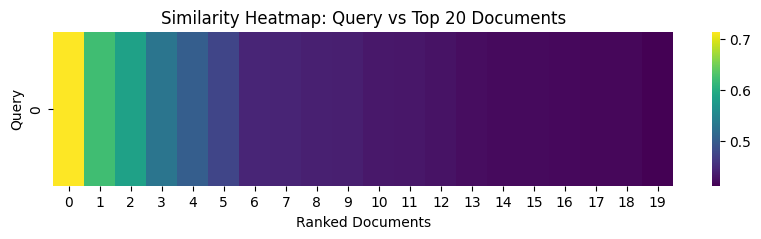

In [ ]:
import seaborn as sns

test_qid = valid_qids[0]
qtext = queries[test_qid]

q_emb = dense_model.encode([qtext], normalize_embeddings=True)[0]
sim_scores = np.dot(doc_embeddings, q_emb)

top_idx = np.argsort(-sim_scores)[:20]
heat_vals = sim_scores[top_idx].reshape(1, -1)

plt.figure(figsize=(10, 2))
sns.heatmap(heat_vals, cmap="viridis", annot=False)
plt.title("Similarity Heatmap: Query vs Top 20 Documents")
plt.xlabel("Ranked Documents")
plt.ylabel("Query")
plt.show()


###8.7.3 Scatter Plot: BM25 Score vs Transformer Score
This scatter plot compares BM25 lexical scores (x-axis) with transformer-based semantic similarity scores (y-axis) for documents retrieved for a single query. Each point represents a document that was retrieved by either or both retrieval methods.

Several distinct patterns can be observed. Documents with high BM25 scores and moderate to high semantic scores indicate strong keyword overlap that is also semantically aligned with the query. In contrast, documents with low BM25 scores but relatively high semantic scores reflect cases where semantic similarity is captured despite limited lexical overlap, such as paraphrases or synonym-based matches.

Additionally, some documents exhibit high BM25 scores but near-zero semantic similarity, suggesting keyword matches that lack deeper semantic relevance. This divergence highlights a key limitation of purely lexical retrieval.

Overall, the spread of points demonstrates that BM25 and transformer-based retrieval capture complementary relevance signals, providing clear motivation for combining both approaches in a hybrid retrieval model.

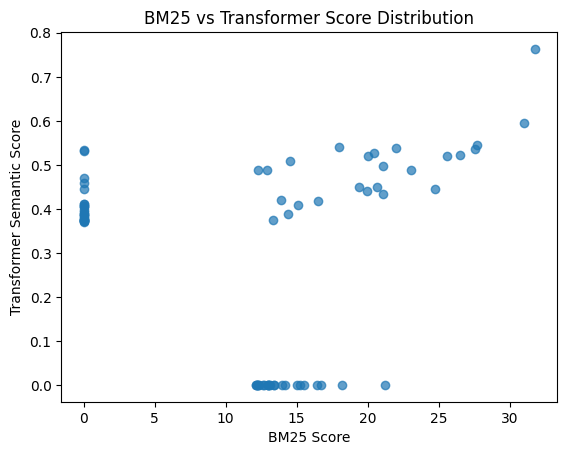

In [ ]:
import random

qid = random.choice(valid_qids)
query = queries[qid]

bm25_res  = bm25_search(query, k=50)
dense_res = dense_search(query, k=50)

pid_scores = {}
for pid, s in bm25_res:
    pid_scores.setdefault(pid, [0,0])
    pid_scores[pid][0] = s

for pid, s in dense_res:
    pid_scores.setdefault(pid, [0,0])
    pid_scores[pid][1] = s

bm = [v[0] for v in pid_scores.values()]
dense = [v[1] for v in pid_scores.values()]

plt.scatter(bm, dense, alpha=0.7)
plt.xlabel("BM25 Score")
plt.ylabel("Transformer Semantic Score")
plt.title("BM25 vs Transformer Score Distribution")
plt.show()


##8.8 Transformer Error Analysis - Identifying Failures

This analysis examines cases where the transformer-based retriever fails to return any relevant passage within the top-10 results. Queries are categorized into successful cases, where a relevant document appears within the top ranks, and failure cases, where no relevant document is retrieved.

Analyzing these failure cases helps identify systematic limitations of dense retrieval, such as short or ambiguous queries and queries requiring precise entity matching. This analysis provides insight into model behavior beyond aggregate evaluation metrics and motivates the use of hybrid retrieval methods.

In [ ]:
def first_rel_rank_dense(qid, k=10):
    rel_set = qrels.get(qid, set())
    results = dense_search(queries[qid], k=k)
    for rank, (d, _) in enumerate(results, start=1):
        if d in rel_set:
            return rank
    return None  # no relevant doc found


In [ ]:
dense_ranks = []
for qid in eval_qids:
    rank = first_rel_rank_dense(qid, k=10)
    dense_ranks.append((qid, rank))

dense_bad = [x for x in dense_ranks if x[1] is None]
dense_good = [x for x in dense_ranks if x[1] is not None and x[1] <= 2]

print("Good cases:", len(dense_good))
print("Bad cases (no relevant in top-10):", len(dense_bad))


Good cases: 667
Bad cases (no relevant in top-10): 17


###8.8.1 Error Distribution Histogram

This histogram shows the distribution of the rank position of the first relevant passage returned by the transformer-based retriever for each query. Lower ranks indicate earlier retrieval of relevant passages, while a value of 11 represents complete failure, where no relevant passage is retrieved within the top-10 results.

The distribution is strongly skewed toward lower ranks, with a large concentration of queries achieving a relevant result at rank 1 or 2. This indicates that the transformer model frequently retrieves relevant passages at top positions. Only a small fraction of queries fall into the failure category (rank 11), demonstrating that complete retrieval failures are relatively rare.

Overall, this distribution highlights the stability and robustness of dense retrieval compared to lexical baselines, while also providing a quantitative view of the model’s remaining limitations.

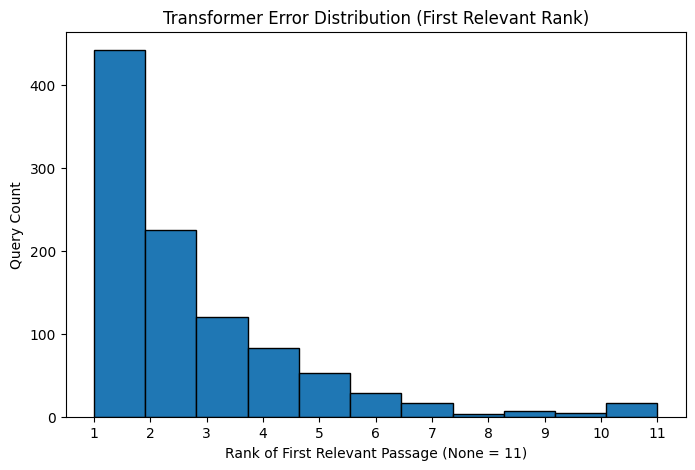

In [ ]:
rank_values = [r if r is not None else 11 for _,r in dense_ranks]

plt.figure(figsize=(8,5))
plt.hist(rank_values, bins=11, edgecolor='black')
plt.xticks(range(1,12))
plt.xlabel("Rank of First Relevant Passage (None = 11)")
plt.ylabel("Query Count")
plt.title("Transformer Error Distribution (First Relevant Rank)")
plt.show()


###8.8.2 Example Good & Bad Cases

This section presents representative examples of successful and failed retrieval cases for the transformer-based dense model. Successful cases correspond to queries where a relevant passage is retrieved at rank 1 or 2, while failure cases correspond to queries where no relevant passage appears in the top-10 results.

Examining individual examples provides qualitative insight into model behavior that is not captured by aggregate evaluation metrics. Successful cases typically involve queries with clear semantic intent, where the model effectively captures contextual meaning. In contrast, failure cases often involve short, ambiguous, or highly specific queries that require precise entity matching or additional contextual information.

This qualitative analysis helps identify systematic strengths and limitations of dense retrieval and motivates the use of hybrid retrieval or re-ranking strategies to address remaining failure modes.

In [ ]:
print("=== GOOD CASES (Dense Model succeeds) ===")
for qid, rank in dense_good[:3]:
    print("\nQuery:", queries[qid])
    print("Rank:", rank)
    print("Relevant Passage:")
    rel_pid = list(qrels[qid])[0]
    print(corpus[rel_pid][:300])


=== GOOD CASES (Dense Model succeeds) ===

Query: )what was the immediate impact of the success of the manhattan project?
Rank: 1
Relevant Passage:
The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of in

Query: _________ justice is designed to repair the harm to victim, the community and the offender caused by the offender criminal act. question 19 options:
Rank: 2
Relevant Passage:
The approach is based on a theory of justice that considers crime and wrongdoing to be an offense against an individual or community, rather than the State. Restorative justice that fosters dialogue between victim and offender has shown the highest rates of victim satisfaction and offender accountab

Query: is autoimmune hepatitis a bile acid synthesis disorder
Rank

In [ ]:
print("=== BAD CASES (Dense Model fails) ===")
for qid, rank in dense_bad[:3]:
    print("\nQuery:", queries[qid])
    print("Top-5 Dense Results:")
    for d, s in dense_search(queries[qid], k=5):
        print(f"Score: {s:.4f} | Doc ID: {d}")
        print("Passage:", corpus[d][:200], "\n")


=== BAD CASES (Dense Model fails) ===

Query: what causes elevation in ast (sgot)
Top-5 Dense Results:
Score: 0.6457 | Doc ID: 5366
Passage: An abnormal high level of blood of SGOT shows the extent of damage to liver and muscles of body. Causes for a high elevated SGOT level may include infection, viral hepatitis, mononucleosis, gallbladde 

Score: 0.5979 | Doc ID: 5362
Passage: The SGOT (serum glutamic-oxaloacetic transminase) or AST test, actually, measures the amount of a protein enzyme called glutamic-oxaloacetic transaminase occurring in human blood of the patient. This  

Score: 0.5663 | Doc ID: 5365
Passage: Both mother and son tested negative for any type of hepatitis. An elevated SGOT usually is a reflection of damage to liver cells. Hepatitis due to virus or drugs is the most likely cause. A value high 

Score: 0.5187 | Doc ID: 47499
Passage: 191 Followers. A. AST (SGOT) and ALT (SGPT) are sensitive indicators of liver damage or injury from different types of diseases. But it

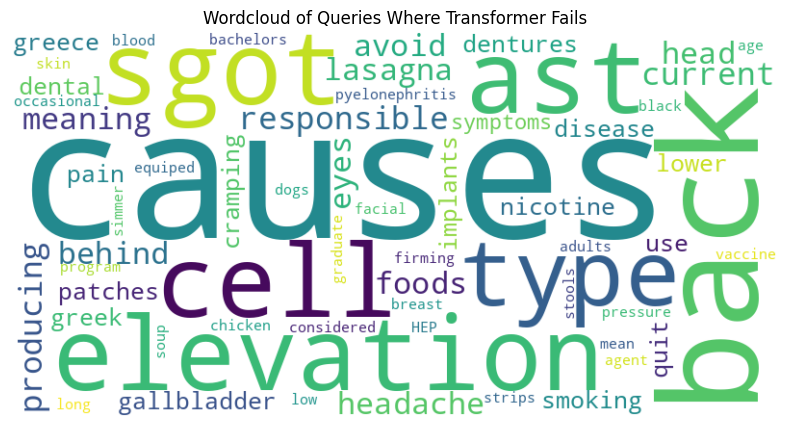

In [ ]:
from wordcloud import WordCloud

bad_query_texts = " ".join([queries[qid] for qid,_ in dense_bad])

wc = WordCloud(width=800, height=400, background_color="white").generate(bad_query_texts)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud of Queries Where Transformer Fails")
plt.show()


## Summary of Transformer Section

The transformer-based semantic retrieval model demonstrates a substantial improvement in retrieval quality by encoding queries and passages into a shared semantic embedding space. By leveraging dense embeddings and FAISS-based similarity search, the model effectively retrieves contextually relevant passages, even in cases where exact keyword overlap is limited.

Comprehensive evaluation using standard ranking metrics, combined with qualitative analyses and error inspection, highlights both the strengths and limitations of dense retrieval. While the model performs robustly on semantically well-formed queries, it remains sensitive to short, ambiguous, or entity-specific queries.

These observations motivate the integration of semantic retrieval with lexical methods, leading naturally to a hybrid retrieval framework that combines the complementary strengths of BM25 and transformer-based embeddings.

## 9 Hybrid Retrieval (BM25 + Semantic Embeddings)

Lexical retrieval models like BM25 excel at exact keyword matching, while
semantic embedding models capture deeper contextual meaning.

In this section, we combine both approaches into a **hybrid search engine**
by fusing their scores using a weighted linear combination.

The goal is to leverage the strengths of both methods to improve ranking quality.


###9.1 Hybrid scoring function

We now define the core `hybrid_search()` function that combines the scores from
BM25 and the dense transformer model.

For a given query:

1. We first retrieve candidate documents using:
   - **BM25** (`bm25_search`) - lexical keyword matching
   - **Dense model** (`dense_search`) - semantic similarity using embeddings
2. We take the **union** of candidate documents from both models.
3. For each candidate document, we compute:
   - a normalized BM25 score
   - a normalized dense similarity score
4. We combine them using a weighted sum controlled by a parameter α:

$$
\text{HybridScore} = \alpha \cdot \text{BM25_norm} + (1 - \alpha)\cdot\text{Dense_norm}
$$


- When **α = 1.0**, the model behaves like pure BM25.
- When **α = 0.0**, the model behaves like the dense semantic model.
- Values in between give a true hybrid of lexical and semantic retrieval.

In [ ]:
def min_max_normalize(scores):
    """
    Normalize scores to [0,1] range
    """
    scores = np.array(scores)
    return (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)

In [ ]:
import numpy as np

def hybrid_search(query_text, alpha=0.4, k_bm25=50, k_dense=50, k=10):

    bm25_results = bm25_search(query_text, k=k_bm25)
    bm25_dict = {doc_id: score for doc_id, score in bm25_results}

    dense_results = dense_search(query_text, k=k_dense)
    dense_dict = {doc_id: score for doc_id, score in dense_results}

    # deterministic candidate order
    candidate_ids = sorted(set(bm25_dict.keys()) | set(dense_dict.keys()))

    if not candidate_ids:
        return bm25_results[:k]

    bm25_scores = np.array([bm25_dict.get(d, 0.0) for d in candidate_ids])
    dense_scores = np.array([dense_dict.get(d, 0.0) for d in candidate_ids])

    bm25_norm = min_max_normalize(bm25_scores)
    dense_norm = min_max_normalize(dense_scores)

    hybrid_scores = alpha * bm25_norm + (1.0 - alpha) * dense_norm

    order = np.argsort(hybrid_scores)[::-1][:k]

    return [(candidate_ids[i], float(hybrid_scores[i])) for i in order]

In [ ]:
def hybrid_search_df(query_text, alpha=0.4, k=10):
    results = hybrid_search(query_text, alpha=alpha, k=k)
    rows = []
    for doc_id, score in results:
        rows.append({
            "doc_id": doc_id,
            "passage": corpus[doc_id],
            "hybrid_score": score
        })
    return pd.DataFrame(rows)

###9.2 Evaluating the hybrid model

The hybrid model is evaluated alongside BM25 and the dense transformer-based model using the same set of queries and **standard retrieval metrics** to ensure a fair comparison. We report **MRR@10, Recall@10, and nDCG@10,** which measure early relevance, coverage of relevant documents, and overall ranking quality, respectively.

The hybrid model combines lexical and semantic scores using a fusion parameter α. Values of **α closer to 1.0** emphasize BM25, while values closer to 0.0 favor dense semantic retrieval. We evaluate the hybrid approach with **α = 0.4** and **α = 0.6** to analyze the effect of different fusion weights on retrieval performance.

In [ ]:
from tqdm import tqdm

EVAL_Q = 1000
eval_qids = valid_qids[:EVAL_Q]   # same as BM25 and dense for fair comparison

# Hybrid alpha = 0.4
rank_lists_hybrid_04 = []

for qid in tqdm(eval_qids, desc="Evaluating hybrid (alpha=0.4)"):
    qtext = queries[qid]
    results = hybrid_search(qtext, alpha=0.4, k=10)
    ranked_docs = [doc_id for doc_id, score in results]
    rank_lists_hybrid_04.append((qid, ranked_docs))

mrr10_hybrid_04 = compute_mrr_at_k(rank_lists_hybrid_04, qrels, k=10)
recall10_hybrid_04 = compute_recall_at_k(rank_lists_hybrid_04, qrels, k=10)
ndcg10_hybrid_04 = compute_ndcg_at_k(rank_lists_hybrid_04, qrels, k=10)

print("Hybrid Results (alpha = 0.4):")
print("MRR@10:", mrr10_hybrid_04)
print("Recall@10:", recall10_hybrid_04)
print("nDCG@10:", ndcg10_hybrid_04)


# Hybrid alpha = 0.6
rank_lists_hybrid_06 = []

for qid in tqdm(eval_qids, desc="Evaluating hybrid (alpha=0.6)"):
    qtext = queries[qid]
    results = hybrid_search(qtext, alpha=0.6, k=10)
    ranked_docs = [doc_id for doc_id, score in results]
    rank_lists_hybrid_06.append((qid, ranked_docs))

mrr10_hybrid_06 = compute_mrr_at_k(rank_lists_hybrid_06, qrels, k=10)
recall10_hybrid_06 = compute_recall_at_k(rank_lists_hybrid_06, qrels, k=10)
ndcg10_hybrid_06 = compute_ndcg_at_k(rank_lists_hybrid_06, qrels, k=10)

print("\nHybrid Results (alpha = 0.6):")
print("MRR@10:", mrr10_hybrid_06)
print("Recall@10:", recall10_hybrid_06)
print("nDCG@10:", ndcg10_hybrid_06)

Evaluating hybrid (alpha=0.4): 100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


Hybrid Results (alpha = 0.4):
MRR@10: 0.5642321428571422
Recall@10: 0.9253333333333332
nDCG@10: 0.699821211272937


Evaluating hybrid (alpha=0.6): 100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


Hybrid Results (alpha = 0.6):
MRR@10: 0.4956761904761893
Recall@10: 0.8831666666666667
nDCG@10: 0.6624867044505393


##10 Metric comparison: BM25 vs Dense vs Hybrid

The bar chart below compares the three models on MRR@10, Recall@10, and nDCG@10.

- BM25 represents traditional lexical retrieval.
- Dense represents semantic retrieval using transformer embeddings.
- Hybrid combines both signals using the weighted fusion described above.

If hybrid fusion is effective, we expect it to **improve over BM25** and often get **closer to Dense**, especially depending on the value of α.

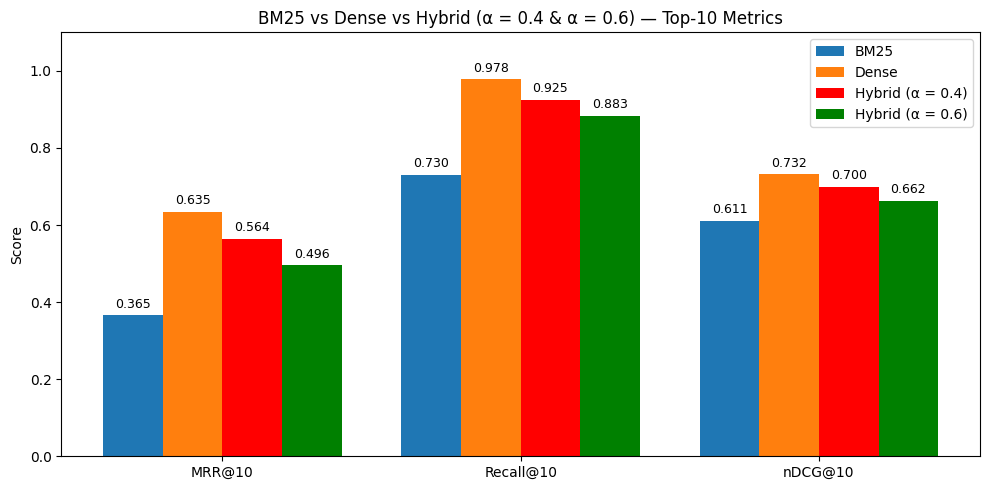

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["MRR@10", "Recall@10", "nDCG@10"]

bm25_vals   = [mrr10,               recall10,               ndcg10]
dense_vals  = [mrr10_dense,         recall10_dense,         ndcg10_dense]
hyb04_vals  = [mrr10_hybrid_04,     recall10_hybrid_04,     ndcg10_hybrid_04]
hyb06_vals  = [mrr10_hybrid_06,     recall10_hybrid_06,     ndcg10_hybrid_06]

x = np.arange(len(metrics))
width = 0.20

plt.figure(figsize=(10,5))

plt.bar(x - 1.5*width, bm25_vals,  width, label="BM25")
plt.bar(x - 0.5*width, dense_vals, width, label="Dense")
plt.bar(x + 0.5*width, hyb04_vals, width, label="Hybrid (α = 0.4)", color="red")
plt.bar(x + 1.5*width, hyb06_vals, width, label="Hybrid (α = 0.6)", color="green")

plt.xticks(x, metrics)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("BM25 vs Dense vs Hybrid (α = 0.4 & α = 0.6) — Top-10 Metrics")

for i, vals in enumerate([bm25_vals, dense_vals, hyb04_vals, hyb06_vals]):
    for j, val in enumerate(vals):
        plt.text(x[j] + (i-1.5)*width, val + 0.02, f"{val:.3f}",
                 ha='center', fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()

###10.1 Qualitative analysis: when does hybrid succeed or fail?

Beyond aggregate metrics, we also inspect individual queries to understand
**when** the hybrid model works well and **when** it fails.

- For each query, we record the rank of the first relevant document in the hybrid ranking.
- We treat cases where the first relevant document is in rank 1 or 2 as "good" cases.
- Queries where **no relevant document appears in the top-10** are treated as "bad" cases.

We then:
- Print examples of good and bad queries with their top-5 results, and
- Build a wordcloud over the bad queries to see what kinds of information needs
  are hardest for the hybrid model.

In [ ]:
def first_rel_rank_hybrid(qid, k=10, alpha=0.4):
    rel_set = qrels.get(qid, set())
    results = hybrid_search(queries[qid], alpha=alpha, k=k)
    for rank, (d, _) in enumerate(results, start=1):
        if d in rel_set:
            return rank
    return None  # no relevant doc found

###10.2 Split Queries into Good vs Bad Cases (Hybrid)

Using the “first relevant rank” helper, we categorize evaluation queries into:
- **Good cases:** first relevant doc appears at rank 1-2
- **Bad cases:** no relevant doc appears in top-10

This helps us analyze what kinds of queries Hybrid handles well vs poorly.

In [ ]:
hybrid_ranks_04 = []
for qid in eval_qids:
    rank = first_rel_rank_hybrid(qid, k=10, alpha=0.4)
    hybrid_ranks_04.append((qid, rank))

hybrid_good_04 = [x for x in hybrid_ranks_04 if x[1] is not None and x[1] <= 2]
hybrid_bad_04  = [x for x in hybrid_ranks_04 if x[1] is None]

print("Hybrid (alpha=0.4) good cases (relevant ranked 1-2):", len(hybrid_good_04))
print("Hybrid (alpha=0.4) bad cases (no relevant in top-10):", len(hybrid_bad_04))

Hybrid (alpha=0.4) good cases (relevant ranked 1–2): 573
Hybrid (alpha=0.4) bad cases (no relevant in top-10): 69


In [ ]:
hybrid_ranks_06 = []
for qid in eval_qids:
    rank = first_rel_rank_hybrid(qid, k=10, alpha=0.6)
    hybrid_ranks_06.append((qid, rank))

hybrid_good_06 = [x for x in hybrid_ranks_06 if x[1] is not None and x[1] <= 2]
hybrid_bad_06  = [x for x in hybrid_ranks_06 if x[1] is None]

print("Hybrid (alpha=0.6) good cases (rank 1-2):", len(hybrid_good_06))
print("Hybrid (alpha=0.6) bad cases (no relevant in top-10):", len(hybrid_bad_06))

Hybrid (alpha=0.6) good cases (rank 1–2): 488
Hybrid (alpha=0.6) bad cases (no relevant in top-10): 109


###10.3 Inspect Example Queries (Qualitative Check)

Here, we print a few sample “good cases” to manually verify:
- what the query is
- where the first relevant doc appears
- what the top-ranked passages look like

This complements quantitative metrics with interpretability.

In [ ]:
print("=== GOOD CASES (Hybrid succeeds) ===")

for qid, rank in hybrid_good_04[:3]:
    print("\nQuery ID:", qid)
    print("Query:", queries[qid])
    print("First Relevant Rank (Hybrid):", rank)

    results = hybrid_search(queries[qid], alpha=0.4, k=5)
    for d, s in results:
        label = "REL" if d in qrels[qid] else "NON-REL"
        print(f"  Score: {s:.4f} | Doc ID: {d} | {label}")
        print("  Passage:", corpus[d][:250], "\n")

=== GOOD CASES (Hybrid succeeds) ===

Query ID: 1185869
Query: )what was the immediate impact of the success of the manhattan project?
First Relevant Rank (Hybrid): 1
  Score: 0.8972 | Doc ID: 0 | REL
  Passage: The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what thei 

  Score: 0.8446 | Doc ID: 2 | NON-REL
  Passage: Essay on The Manhattan Project - The Manhattan Project The Manhattan Project was to see if making an atomic bomb possible. The success of this project would forever change the world forever making it known that something this powerful can be manmade. 

  Score: 0.8347 | Doc ID: 1 | NON-REL
  Passage: The Manhattan Project and its atomic bomb helped bring an end to World War II. Its legacy of peaceful uses of atomic energy continues to have an impact on history and science. 

  Scor

In [ ]:
print("=== GOOD CASES (Hybrid α = 0.6 succeeds) ===")

for qid, rank in hybrid_good_06[:3]:
    print("\nQuery ID:", qid)
    print("Query:", queries[qid])
    print("First Relevant Rank (Hybrid α = 0.6):", rank)

    results = hybrid_search(queries[qid], alpha=0.6, k=5)
    for d, s in results:
        label = "REL" if d in qrels[qid] else "NON-REL"
        print(f"  Score: {s:.4f} | Doc ID: {d} | {label}")
        print("  Passage:", corpus[d][:250], "\n")

=== GOOD CASES (Hybrid α = 0.6 succeeds) ===

Query ID: 1185869
Query: )what was the immediate impact of the success of the manhattan project?
First Relevant Rank (Hybrid α = 0.6): 2
  Score: 0.8964 | Doc ID: 2 | NON-REL
  Passage: Essay on The Manhattan Project - The Manhattan Project The Manhattan Project was to see if making an atomic bomb possible. The success of this project would forever change the world forever making it known that something this powerful can be manmade. 

  Score: 0.8458 | Doc ID: 0 | REL
  Passage: The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what thei 

  Score: 0.8170 | Doc ID: 1 | NON-REL
  Passage: The Manhattan Project and its atomic bomb helped bring an end to World War II. Its legacy of peaceful uses of atomic energy continues to have an impact on history and s

In [ ]:
print("=== BAD CASES (Hybrid fails) ===")

for qid, rank in hybrid_bad_04[:3]:
    print("\nQuery ID:", qid)
    print("Query:", queries[qid])
    print("Hybrid: No relevant doc in top-10")

    results = hybrid_search(queries[qid], alpha=0.4, k=5)
    for d, s in results:
        label = "REL" if d in qrels[qid] else "NON-REL"
        print(f"  Score: {s:.4f} | Doc ID: {d} | {label}")
        print("  Passage:", corpus[d][:250], "\n")

=== BAD CASES (Hybrid fails) ===

Query ID: 460668
Query: mushrooms health benefits
Hybrid: No relevant doc in top-10
  Score: 0.9903 | Doc ID: 1937 | NON-REL
  Passage: Health Benefits of Portobello Mushrooms. Of the 140,000 fungi known to produce mushrooms, only about 100 of them are being investigated for possible health-promoting benefits. 

  Score: 0.9412 | Doc ID: 1932 | NON-REL
  Passage: Weil is less enthusiastic about white, or button, mushrooms, a species of mushroom that also includes Portobellos and criminis. âButton mushrooms do possess some health benefits, but not the general health benefits found in Asian mushrooms,â Weil 

  Score: 0.8725 | Doc ID: 1935 | NON-REL
  Passage: For thousands of years, Eastern cultures have revered mushroomsâ health benefits.1 Mushrooms have long been celebrated as a source of powerful nutrients, but they can also help Americans meet the dietary recommendations set forth in the 2010 Dietar 

  Score: 0.7986 | Doc ID: 102915 | NON-REL

In [ ]:
print("=== BAD CASES (Hybrid fails) ===")

for qid, rank in hybrid_bad_06[:3]:
    print("\nQuery ID:", qid)
    print("Query:", queries[qid])
    print("Hybrid: No relevant doc in top-10")

    results = hybrid_search(queries[qid], alpha=0.6, k=5)
    for d, s in results:
        label = "REL" if d in qrels[qid] else "NON-REL"
        print(f"  Score: {s:.4f} | Doc ID: {d} | {label}")
        print("  Passage:", corpus[d][:250], "\n")

=== BAD CASES (Hybrid fails) ===

Query ID: 460668
Query: mushrooms health benefits
Hybrid: No relevant doc in top-10
  Score: 0.9935 | Doc ID: 1937 | NON-REL
  Passage: Health Benefits of Portobello Mushrooms. Of the 140,000 fungi known to produce mushrooms, only about 100 of them are being investigated for possible health-promoting benefits. 

  Score: 0.9302 | Doc ID: 1932 | NON-REL
  Passage: Weil is less enthusiastic about white, or button, mushrooms, a species of mushroom that also includes Portobellos and criminis. âButton mushrooms do possess some health benefits, but not the general health benefits found in Asian mushrooms,â Weil 

  Score: 0.8170 | Doc ID: 1935 | NON-REL
  Passage: For thousands of years, Eastern cultures have revered mushroomsâ health benefits.1 Mushrooms have long been celebrated as a source of powerful nutrients, but they can also help Americans meet the dietary recommendations set forth in the 2010 Dietar 

  Score: 0.7794 | Doc ID: 1936 | NON-REL
 

###10.4 Comparing Failure Patterns Across α

Because α changes the balance between lexical vs semantic signals, it can also change which queries fail.

Here we generate wordclouds for failure queries under:
- Hybrid α = 0.4
- Hybrid α = 0.6

This helps us see whether certain query types are more sensitive to the fusion weight.

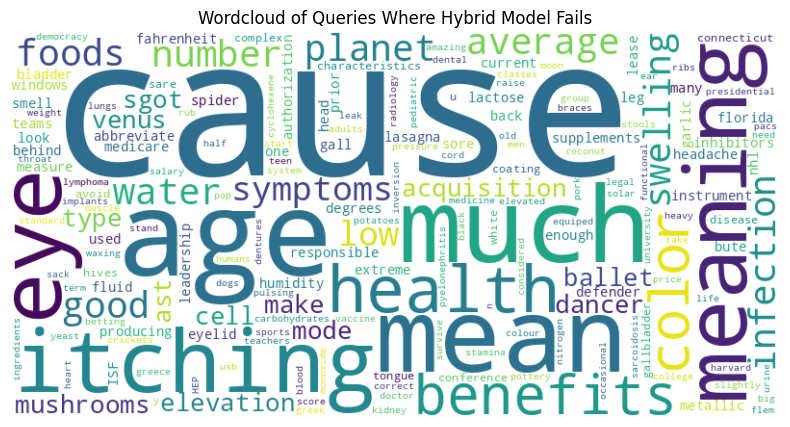

In [ ]:
from wordcloud import WordCloud

bad_query_texts_hybrid = " ".join([queries[qid] for qid, _ in hybrid_bad_04])

wc = WordCloud(width=800, height=400, background_color="white").generate(bad_query_texts_hybrid)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud of Queries Where Hybrid Model Fails")
plt.show()

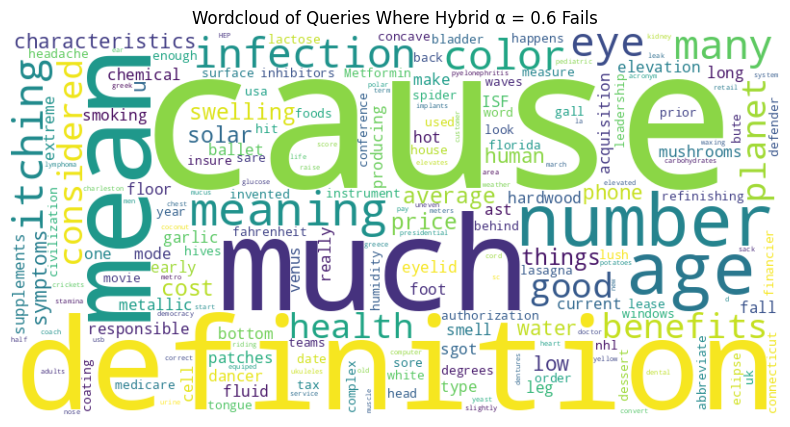

In [ ]:
bad_query_texts_hybrid_06 = " ".join([queries[qid] for qid, _ in hybrid_bad_06])

wc = WordCloud(width=800, height=400, background_color="white").generate(bad_query_texts_hybrid_06)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud of Queries Where Hybrid α = 0.6 Fails")
plt.show()

###10.5 Score Behavior Visualization (Single Query)

Metrics summarize overall performance, but do not show *how* scores behave per query.  
For a sample query, we plot **normalized score curves** for:
- BM25
- Dense
- Hybrid (α=0.4)
- Hybrid (α=0.6)

This helps explain the ranking behavior and how fusion shifts results between lexical vs semantic signals.

Query: what is artificial intelligence


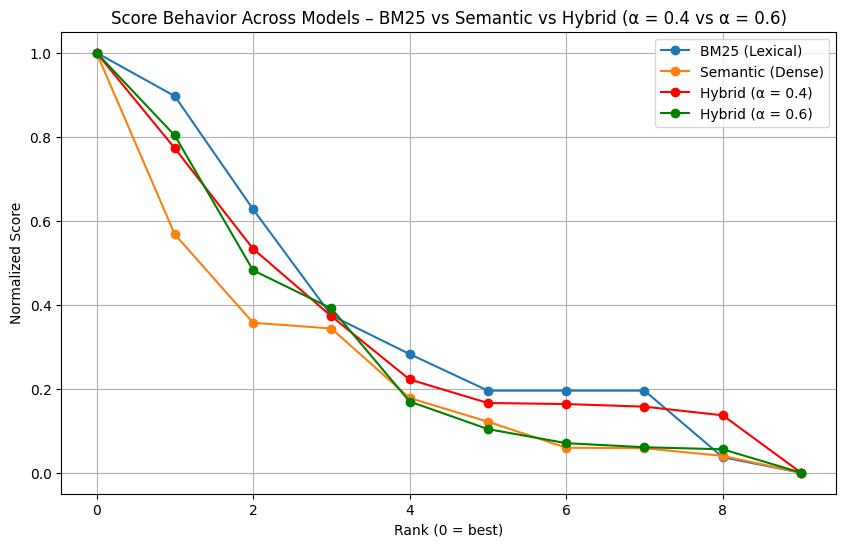


=== BM25: Top-3 Results ===

Rank 1 | doc_id = 70196 | score = 19.8756
Artificial intelligence is the search for a way to map intelligence into mechanical hardware and enable a structure into that system to formalize thought. No formal definition, as yet, is available for as to what artificial intelligence actually is.  ...


Rank 2 | doc_id = 143258 | score = 19.2838
Artificial intelligence is changing the way lawyers think, the way they do business and the way they interact with clients. Artificial intelligence is more than legal technology. It is the next great hope that will revolutionize the legal profession. ...


Rank 3 | doc_id = 173166 | score = 17.7419
In the world of 2001, people have become so machinelike that the most human character turns out to be a machine. Thatâs the essence of Kubrickâs dark prophecy: as we come to rely on computers to mediate our understanding of the world, it is our o ...


=== Semantic: Top-3 Results ===

Rank 1 | doc_id = 70196 | score = 0.86

In [ ]:
query = "what is artificial intelligence"
print("Query:", query)

bm25_res   = bm25_search(query, k=10)
dense_res  = dense_search(query, k=10)
hyb_res_04 = hybrid_search(query, alpha=0.4, k=10)
hyb_res_06 = hybrid_search(query, alpha=0.6, k=10)

def extract_normalized_scores(results):
    doc_ids = [doc_id for doc_id, _ in results]
    scores  = np.array([score for _, score in results])
    return doc_ids, min_max_normalize(scores)

bm25_docs,  bm25_scores_norm    = extract_normalized_scores(bm25_res)
dense_docs, dense_scores_norm   = extract_normalized_scores(dense_res)
hyb_docs_04, hyb_scores_norm_04 = extract_normalized_scores(hyb_res_04)
hyb_docs_06, hyb_scores_norm_06 = extract_normalized_scores(hyb_res_06)

plt.figure(figsize=(10, 6))
plt.plot(bm25_scores_norm,    label="BM25 (Lexical)",    marker="o")
plt.plot(dense_scores_norm,   label="Semantic (Dense)",  marker="o")
plt.plot(hyb_scores_norm_04,  label="Hybrid (α = 0.4)",  marker="o", color="red")
plt.plot(hyb_scores_norm_06,  label="Hybrid (α = 0.6)",  marker="o", color="green")

plt.title("Score Behavior Across Models - BM25 vs Semantic vs Hybrid (α = 0.4 vs α = 0.6)")
plt.xlabel("Rank (0 = best)")
plt.ylabel("Normalized Score")
plt.grid(True)
plt.legend()
plt.show()

def show_top3(name, results):
    print(f"\n=== {name}: Top-3 Results ===")
    for i, (doc_id, score) in enumerate(results[:3], start=1):
        print(f"\nRank {i} | doc_id = {doc_id} | score = {score:.4f}")
        print(corpus[doc_id][:250].replace("\n", " "), "...\n")

show_top3("BM25", bm25_res)
show_top3("Semantic", dense_res)
show_top3("Hybrid α = 0.4", hyb_res_04)
show_top3("Hybrid α = 0.6", hyb_res_06)

## Conclusion: Hybrid Retrieval

The hybrid search model combines BM25’s lexical matching with the semantic understanding of dense embeddings, aiming to leverage the strengths of both approaches. According to our experiments, dense retrieval consistently outperforms BM25 across MRR@10, Recall@10, and nDCG@10. The hybrid models with
𝛼 = 0.4 and 𝛼 = 0.6 generally fall between BM25 and dense performance.

Specifically, the hybrid with 𝛼 = 0.4 shows slightly better performance than
𝛼 = 0.6, indicating that giving more weight to dense embeddings improves retrieval metrics, but still does not surpass pure dense retrieval. This suggests that while the hybrid approach balances lexical and semantic signals, dense embeddings dominate performance on top-10 metrics in this setting.

Overall, the hybrid system offers a middle ground between BM25 and dense retrieval, providing more robust relevance than BM25 alone, though in this experiment, pure dense retrieval remains the strongest for top-10 document ranking.